# Quantum Approximate Optimization Algorithm using Gate-based QC

This notebook consists of a implementation of multi anlge QAOA (or ma-QAOA) using Pennylane.

In [1]:
# Importing required libraries

# General imports
import time
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

# Libraries for Model Formulation
from docplex.mp.model import Model
from scipy.optimize import minimize

# Qiskit Imports
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp

# Library for circuit simulation
import pennylane as qml

# Library for Graph creation
import networkx as nx

## Building the model and its Cost Function 
We are using ***docplex*** to build the model and calculate $Q$ and $c$.

In [2]:
# Function to sort the count dictionary.
def find_most_common_solutions(input_dict, n):
    sorted_keys = sorted(input_dict, key=input_dict.get, reverse=True)
    return sorted_keys[:n]

# Function to plot the graph
def draw_graph(G, colors, pos):
    default_axes = plt.axes()
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    # edge_labels = nx.get_edge_attributes(G, "weight")
    return None

# Returns the flat index of the matrix given the row and column indices.
def flat_index(n: int, i: int, j: int) -> int:
    return int(n*i + j)

# Function to print the solution
def print_solution_maxcut(graph: nx.Graph, counts: dict) -> None:
    
    # Printing Solutions Sets.
    best_sol = find_most_common_solutions(counts,3)
    print(f'\n\nTop 3 solutions for the graph {graph} and {layers} layers: \n{best_sol}')

    def plot_solution(G,pos,results):
        c = ["r" if b == "0" else "c" for b in find_most_common_solutions(results, 1)[0]]
        draw_graph(G, c, pos)

    pos = nx.spring_layout(graph)
    plot_solution(graph,pos,counts)

    return None

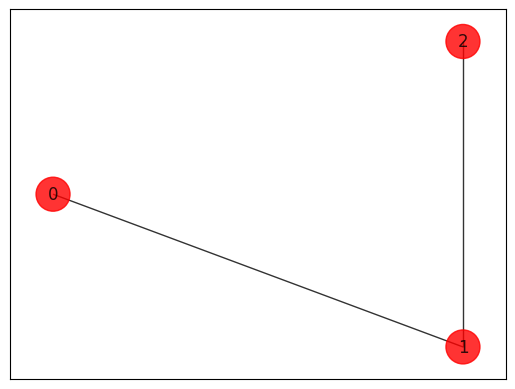

In [3]:
# Initializing a Graph Instance.

# Generating a graph of 3 nodes
# Nodes in the Graph.
n = 3  # Number of nodes in graph
G3 = nx.Graph()
G3.add_nodes_from(np.arange(0, n, 1))

# Edges in the Graph.
edges = [(0, 1, 1.0), (1, 2, 1.0)]
G3.add_weighted_edges_from(edges)

# Colors and Positions for displaying the Graph.
colors = ["r" for node in G3.nodes()]
pos_3 = nx.shell_layout(G3)

draw_graph(G3, colors, pos_3)

In [4]:
def build_qubo_maxcut(graph: nx.Graph):

    n_nodes = graph.number_of_nodes()
    edges = graph.edges()
    
    model = Model()

    x = model.binary_var_list(n_nodes)
    Q = -1*sum(graph.get_edge_data(i,j).get('weight')*x[i]*(1-x[j]) for i,j in edges)

    model.minimize(Q)

    problem = from_docplex_mp(model)
    converter = QuadraticProgramToQubo()
    qubo = converter.convert(problem)

    return qubo

## Creating the QAOA circuit and layers.

I'm using ***Pennylane*** to handle the circuit simulations. I have created functions to generate the QAOA circuit given $Q$ and $c$.

In [5]:
# Defining the Cost and the Layers of ma-QAOA.

# Cost Layer for Maxcut.
def U_C(gamma:np.ndarray,weights_dict:dict,num_qubits:int):
    gamma_count = 0
    for (wire1, wire2) in weights_dict.keys():
        if wire1<wire2:
            qml.CNOT(wires=[wire1, wire2])
            qml.RZ(2*weights_dict[(wire1, wire2)]*gamma[gamma_count],wires=wire2)
            qml.CNOT(wires=[wire1, wire2])
            gamma_count += 1
    return None

# Mixer Layer.
def U_M(betas:np.ndarray,num_qubits:int):
    for qubit in range(num_qubits):
        qml.RX(2*betas[qubit],wires=qubit)
    return None

In [6]:
# Function to generate the QAOA circuit given the parameters and coefficients.
def qaoa_circuit_generator(num_qubits:int,layers:int,gammas:np.ndarray,betas:np.ndarray,weights_dict:dict) -> dict:
    # Defining the QAOA circuit.
    dev = qml.device("lightning.qubit", wires=num_qubits, shots=1024)
    @qml.qnode(dev)
    def circuit(gammas:np.ndarray,betas:np.ndarray,weights_dict:dict):

        n_edges = len(weights_dict)

        # Creating the |+> plus state
        for qubit in range(num_qubits):
            qml.Hadamard(wires=qubit)

        qml.Barrier()

        # Iterating over the layers.
        for layer in range(layers):
            U_C(gammas[layer*n_edges:(layer+1)*n_edges],weights_dict,num_qubits)
            qml.Barrier()
            
            U_M(betas[layer*num_qubits:(layer+1)*num_qubits],num_qubits)
            qml.Barrier()

        return qml.counts(wires=range(num_qubits))

    return circuit(gammas,betas,weights_dict)

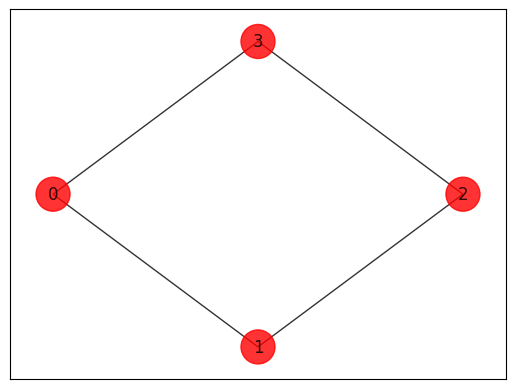

In [7]:
# Generating a graph of 4 nodes
# Nodes in the Graph.
n = 4  # Number of nodes in graph
G4 = nx.Graph()
G4.add_nodes_from(np.arange(0, n, 1))

# Edges in the Graph.
edges = [(0, 1, 1.0), (1, 2, 1.0), (2, 3, 1.0), (0, 3, 1.0)]
G4.add_weighted_edges_from(edges)

# Colors and Positions for displaying the Graph.
colors = ["r" for node in G4.nodes()]
pos_4 = nx.shell_layout(G4)

draw_graph(G4, colors, pos_4)

In [8]:
# Function to create a dictionary of edge weights with key as the tuple of nodes. 
def edge_weight(graph: nx.Graph):
    edge_dict = {}
    for (i,j) in graph.edges():
        w = graph.edges()[i,j]['weight']
        edge_dict[(i,j)] = w
    return edge_dict

Iteration: 1 - Cost: -0.0
Iteration: 2 - Cost: 1.0
Iteration: 3 - Cost: 1.0
Iteration: 4 - Cost: 1.0
Iteration: 5 - Cost: 1.0
Iteration: 6 - Cost: 1.0
Iteration: 7 - Cost: -0.0
Iteration: 8 - Cost: -0.0
Iteration: 9 - Cost: -0.0
Iteration: 10 - Cost: 1.0
Iteration: 11 - Cost: -0.0
Iteration: 12 - Cost: 1.0
Iteration: 13 - Cost: -0.0
Iteration: 14 - Cost: 1.0
Iteration: 15 - Cost: 1.0
Iteration: 16 - Cost: -0.0
Iteration: 17 - Cost: 1.0
Iteration: 18 - Cost: -0.0
Iteration: 19 - Cost: 1.0
Iteration: 20 - Cost: 1.0
Iteration: 21 - Cost: 1.0
Iteration: 22 - Cost: -0.0
Iteration: 23 - Cost: -0.0
Iteration: 24 - Cost: -0.0
Iteration: 25 - Cost: 1.0
Iteration: 26 - Cost: -0.0
Iteration: 27 - Cost: -0.0
Iteration: 28 - Cost: 1.0
Iteration: 29 - Cost: 1.0
Iteration: 30 - Cost: 1.0
Iteration: 31 - Cost: -0.0
Iteration: 32 - Cost: -0.0
Iteration: 33 - Cost: 1.0
Iteration: 34 - Cost: 1.0
Iteration: 35 - Cost: 1.0
Iteration: 36 - Cost: -0.0
Iteration: 37 - Cost: 1.0
Iteration: 38 - Cost: -0.0
Iter

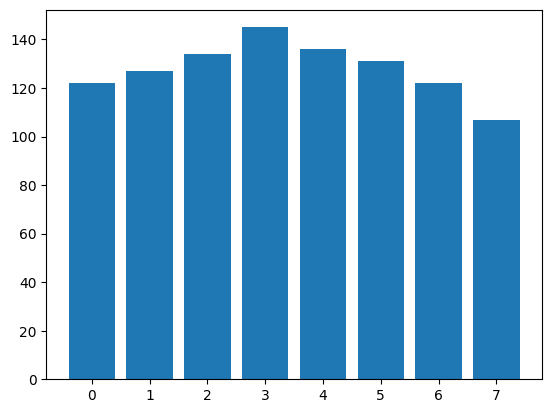

In [17]:
def ma_qaoa_maxcut(graph: nx.Graph,layers:int):

    # Building the QUBO model and graph parameters
    qubo = build_qubo_maxcut(graph)
    num_qubits = graph.number_of_nodes()
    n_edges = graph.number_of_edges()
    weights_dict = edge_weight(graph)
    
    # Initial guess
    init_gamma = np.array([pi/5]*n_edges*layers)
    init_beta = np.array([pi/8]*num_qubits*layers)
    initial_guess = np.concatenate((init_gamma, init_beta))
    
    def expectation_value(theta:np.ndarray,callback_dict:dict):

        sep = int(n_edges*layers)
        gammas = theta[:sep]
        betas = theta[sep:]

        counts = qaoa_circuit_generator(num_qubits, layers, gammas, betas, weights_dict)
        best_sol = find_most_common_solutions(counts,1)[0]

        exp = qubo.objective.evaluate(np.array(list(best_sol), dtype='int'))

        callback_dict["iters"] += 1
        callback_dict["prev_vector"].append(theta)
        callback_dict["cost_history"].append(-1*exp)

        print(f'Iteration: {callback_dict["iters"]} - Cost: {callback_dict["cost_history"][-1]}')

        return exp

    callback_dict = {
        "prev_vector": [],
        "iters": 0,
        "cost_history": [],
    }

    # Minimization of the objective function.
    start_time = time.time()

    # # Minimize the cost function using scipy
    res = minimize(
        expectation_value, 
        initial_guess, 
        args=(callback_dict), 
        method="cobyla", # Classical optimizer
        options={'maxiter': 100}) # Maximum number of iterations

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f'Elapsed time for QAOA: {round(elapsed_time,2)} seconds')
    
    sep = int(n_edges*layers)
    prime_gammas = res.x[:sep]
    prime_betas = res.x[sep:]

    print(f'Gammas: {prime_gammas}\nBetas: {prime_betas}')

    counts = qaoa_circuit_generator(num_qubits,layers,prime_gammas, prime_betas, weights_dict)
    
    return counts, callback_dict

# Defining a test array
layers = 1

# Running QAOA on for Number Partitioning. 
counts, callback = ma_qaoa_maxcut(G3,layers)

print(f"Counts:\n{counts}\n")

# Potting
plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.show()

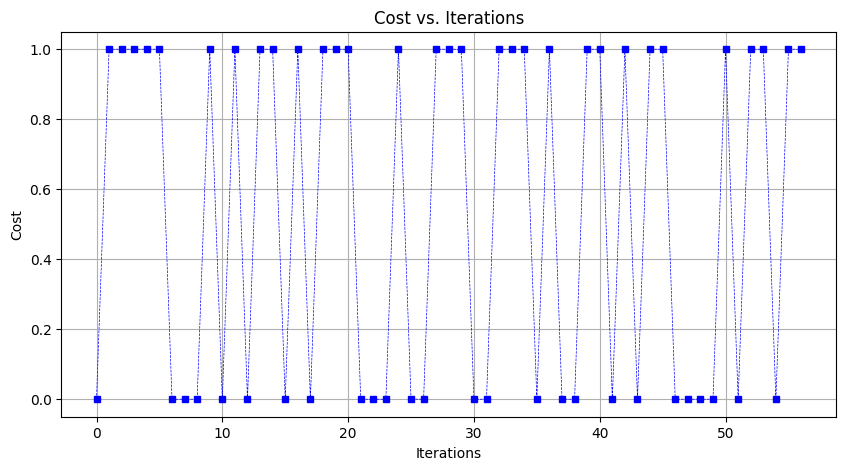

In [18]:
def plot_cost(callback_dict:dict):
    cost = callback_dict["cost_history"]
    iter = list(range(callback_dict["iters"]))
    # Plotting Cost vs. Iterations

    plt.figure(figsize=(10, 5),dpi=100)
    plt.plot(iter,cost,c='blue',ls='--',lw=0.5,marker='s',ms=4)
    plt.grid()
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Cost vs. Iterations')
    plt.show()

plot_cost(callback)



Top 3 solutions for the graph Graph with 3 nodes and 2 edges and 1 layers: 
['011', '100', '010']


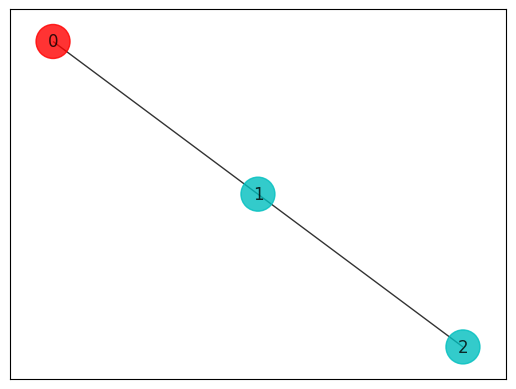

In [19]:
print_solution_maxcut(G3,counts)

In [12]:
def plot_circuit(graph: nx.Graph,layers:int):

    num_qubits = graph.number_of_nodes()
    n_edges = graph.number_of_edges()
    weights_dict = edge_weight(graph)

    dev = qml.device("lightning.qubit", wires=num_qubits, shots=1024)
    @qml.qnode(dev)
    def circuit(gammas:np.ndarray,betas:np.ndarray,weights_dict:dict):

        n_edges = len(weights_dict)

        # Creating the |+> plus state
        for qubit in range(num_qubits):
            qml.Hadamard(wires=qubit)

        qml.Barrier()

        # Iterating over the layers.
        for layer in range(layers):
            U_C(gammas[layer*n_edges:(layer+1)*n_edges],weights_dict,num_qubits)
            qml.Barrier()
            
            U_M(betas[layer*num_qubits:(layer+1)*num_qubits],num_qubits)
            qml.Barrier()

        return qml.counts(wires=range(num_qubits))
    
    gammas = np.array([pi/5]*n_edges*layers)
    betas = np.array([pi/5]*num_qubits*layers)
    
    qml.draw_mpl(circuit)(gammas,betas,weights_dict)

    return None

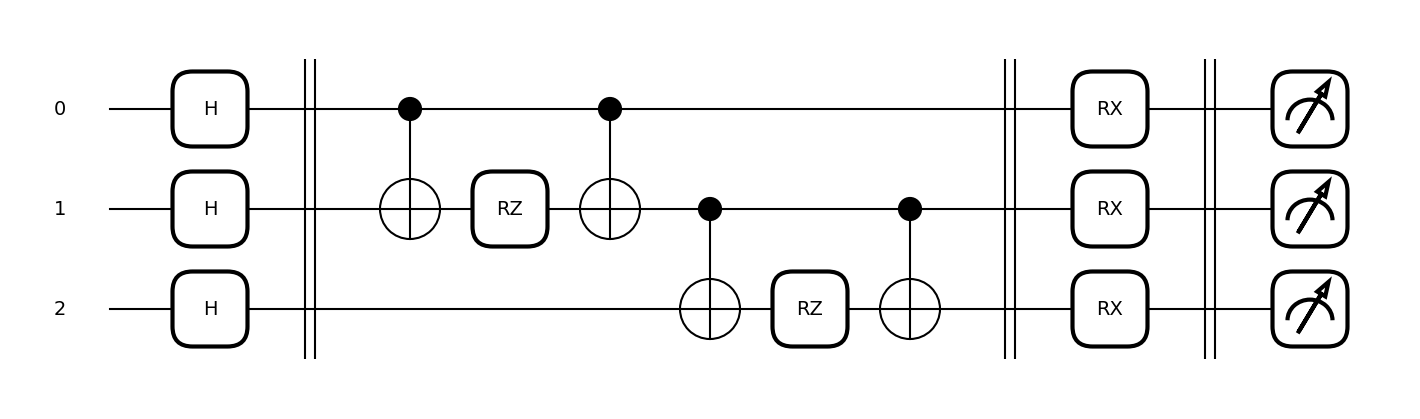

In [13]:
plot_circuit(G3,layers)

In [14]:
def qml_to_qasm(graph: nx.Graph,layers:int):

    num_qubits = graph.number_of_nodes()
    n_edges = graph.number_of_edges()
    weights_dict = edge_weight(graph)

    dev = qml.device("lightning.qubit", wires=num_qubits, shots=1024)
    @qml.qnode(dev)
    def circuit(gammas:np.ndarray,betas:np.ndarray,weights_dict:dict):

        n_edges = len(weights_dict)

        # Creating the |+> plus state
        for qubit in range(num_qubits):
            qml.Hadamard(wires=qubit)

        qml.Barrier()

        # Iterating over the layers.
        for layer in range(layers):
            U_C(gammas[layer*n_edges:(layer+1)*n_edges],weights_dict,num_qubits)
            qml.Barrier()
            
            U_M(betas[layer*num_qubits:(layer+1)*num_qubits],num_qubits)
            qml.Barrier()

        return qml.counts(wires=range(num_qubits))
    
    gammas = np.array([pi/5]*n_edges*layers)
    betas = np.array([pi/5]*num_qubits*layers)
    
    circuit.construct([gammas,betas,weights_dict], {})
    qasm_circ = circuit.qtape.to_openqasm()
    return qasm_circ

In [15]:
# print(qml_to_qasm(G3,2))